# 📰Fake News & Sentiment Detection System Using NLP and Transformers

## 📌 Problem Statement (Brief)

We are working on a **Fake News Detection** problem using **Natural Language Processing (NLP)**.

- We have **~45,000 news articles** (about **22k real** + **22k fake**).
- The **goal** is to build a machine learning model that can **classify whether a given news article is real or fake**.
- This is a **binary classification problem**:
  - `Real = 1`
  - `Fake = 0`


In [ ]:
# ==============================
# 1. IMPORTS & SETUP
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

# Download NLTK resources if not present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive')
real = "/content/drive/MyDrive/Colab Notebooks/True.csv"
fake = "/content/drive/MyDrive/Colab Notebooks/Fake.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sample of the datasets
real = pd.read_csv(real)
fake = pd.read_csv(fake)
display(real.sample(5))
display(fake.sample(5))

,title,text,subject,date
17914,"Fukushima court rules Tepco, government liable...",TOKYO (Reuters) - A district court in Fukushim...,worldnews,"October 10, 2017"
331,"In Brussels, Tillerson offers EU strong U.S. s...",BRUSSELS (Reuters) - U.S. Secretary of State R...,politicsNews,"December 5, 2017"
1632,North Korea official says North may consider h...,SEOUL (Reuters) - North Korean Foreign Ministe...,politicsNews,"September 22, 2017"
6292,Trump's Commerce pick Wilbur Ross is no strang...,WASHINGTON (Reuters) - When billionaire invest...,politicsNews,"January 10, 2017"
12095,Australia arrests man accused of trying to sel...,MELBOURNE (Reuters) - Australian police said o...,worldnews,"December 17, 2017"


,title,text,subject,date
13629,WATCH: BEST DESCRIPTION OF UK BREXIT YET…Conse...,Take note America,politics,"Jun 26, 2016"
902,"Trump Embarrasses America Again, Lets Ivanka ...",Despite claiming to look forward to the second...,News,"July 8, 2017"
9933,‘Empty Barrels Make the Most Noise’ – General ...,Fox News received an email from General John K...,politics,"Sep 11, 2017"
2543,"Trump Wants More White House Staffers, What H...",Donald Trump has just come up with a new way t...,News,"February 13, 2017"
8409,Bigots Upset Their Daughter Was Taught World ...,John and Melissa Wood are typical right-wing l...,News,"January 31, 2016"


In [ ]:
# Load your data 
real['label'] = 1  # Real news
fake['label'] = 0  # Fake news

# Combine datasets
data = pd.concat([real, fake], ignore_index=True)

# Create a combined text column (title + text for better performance)
data['combined_text'] = data['title'].fillna('') + ' ' + data['text'].fillna('')

print(f"Dataset shape: {data.shape}")
print(f"Label distribution:\n{data['label'].value_counts()}")


Dataset shape: (44898, 6)
Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64


In [ ]:
# ==============================
# 2. DATA OVERVIEW
# ==============================

print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())

print("\nLabel Distribution:")
print(data['label'].value_counts())

# Show first rows
data.head()


Dataset Shape: (44898, 6)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          44898 non-null  object
 1   text           44898 non-null  object
 2   subject        44898 non-null  object
 3   date           44898 non-null  object
 4   label          44898 non-null  int64 
 5   combined_text  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB
None

Label Distribution:
label
0    23481
1    21417
Name: count, dtype: int64


,title,text,subject,date,label,combined_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


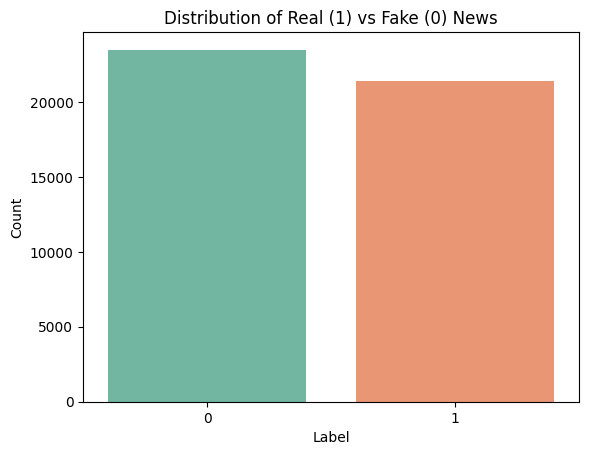

In [ ]:
# Class balance visualization
sns.countplot(x='label', data=data, palette='Set2')
plt.title("Distribution of Real (1) vs Fake (0) News")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

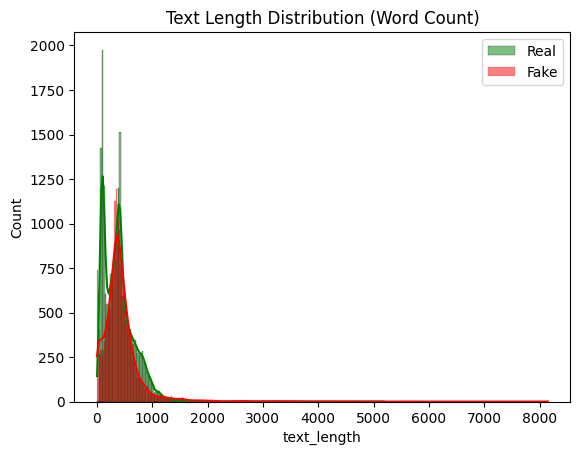

In [ ]:
# Create text length feature
data['text_length'] = data['combined_text'].apply(lambda x: len(x.split()))

sns.histplot(data[data['label']==1]['text_length'], color='green', label='Real', kde=True)
sns.histplot(data[data['label']==0]['text_length'], color='red', label='Fake', kde=True)
plt.legend()
plt.title("Text Length Distribution (Word Count)")
plt.show()

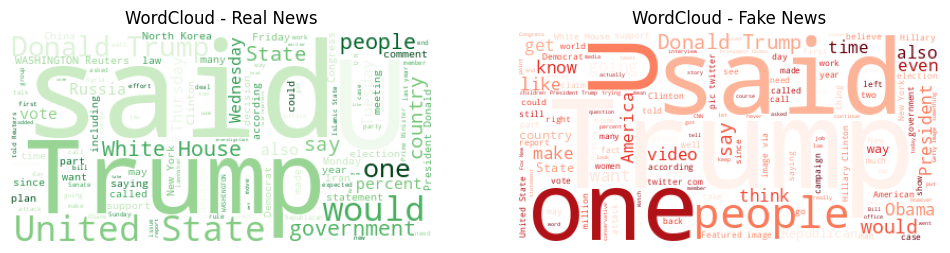

In [ ]:
# WordClouds for real vs fake
real_text = " ".join(data[data['label']==1]['combined_text'])
fake_text = " ".join(data[data['label']==0]['combined_text'])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(WordCloud(stopwords=set(stopwords.words('english')),
                      background_color="white",
                      colormap="Greens").generate(real_text))
plt.title("WordCloud - Real News")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(stopwords=set(stopwords.words('english')),
                      background_color="white",
                      colormap="Reds").generate(fake_text))
plt.title("WordCloud - Fake News")
plt.axis("off")

plt.show()


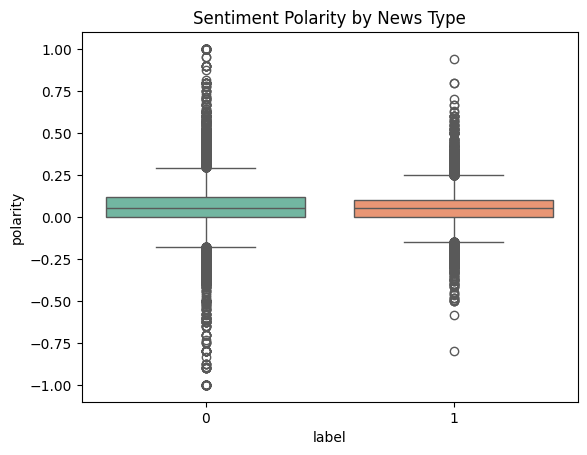

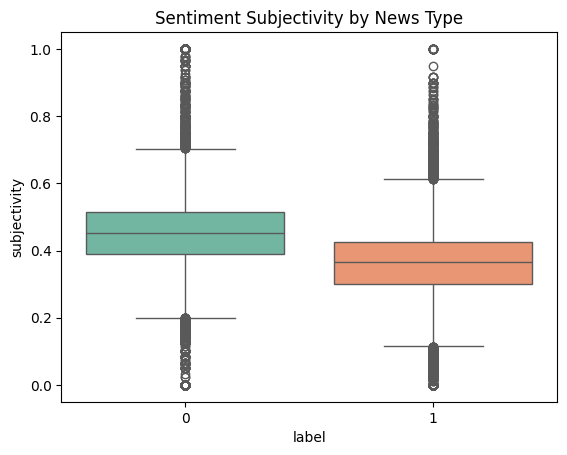

In [ ]:
# Sentiment (polarity & subjectivity)
data['polarity'] = data['combined_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data['combined_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure()
sns.boxplot(x='label', y='polarity', data=data, palette="Set2")
plt.title("Sentiment Polarity by News Type")
plt.show()

plt.figure()
sns.boxplot(x='label', y='subjectivity', data=data, palette="Set2")
plt.title("Sentiment Subjectivity by News Type")
plt.show()


## insights and explainations



# 📊 Exploratory Data Analysis (EDA)

In this section, we explore the **Fake News Dataset** to understand its structure, distribution, and text characteristics before moving to model building.

---

## 🔹 Dataset Overview
- The dataset contains **~45,000 news articles** (real + fake combined).  
- Each record has:
  - **title** (headline of the news)
  - **text** (main content of the article)
  - **label** (`1 = Real`, `0 = Fake`)

We also created a new column:  
➡️ **`combined_text = title + text`** to ensure both headline and body are used for analysis.

---

## 🔹 Class Distribution
- The dataset is **balanced** with almost equal numbers of **Real** and **Fake** news.  
- This balance is important for training models, as it prevents bias toward one class.

📌 *Insight*: Models trained on balanced data usually perform more fairly across classes.

---

## 🔹 Text Length Analysis
- By calculating the **word count per article**, we observed differences between real and fake news:
  - **Real news** articles are generally **longer** with more descriptive content.  
  - **Fake news** articles are often **shorter**, possibly to attract quick attention.

📌 *Insight*: Article length can be a **useful feature** in distinguishing fake vs real.

---

## 🔹 Word Cloud Visualization
- **Real News** word clouds highlight terms like *“said”, “government”, “president”*, which reflect factual reporting.  
- **Fake News** word clouds show attention-grabbing terms like *“breaking”, “shocking”, “secret”*, often used for clickbait.

📌 *Insight*: Fake news tends to use **sensational vocabulary**, while real news uses more **neutral, factual terms**.

---

## 🔹 Sentiment Analysis
Using **TextBlob**, we extracted:
- **Polarity** (how positive/negative the text is)  
- **Subjectivity** (how opinionated vs factual the text is)  

Findings:
- **Fake news** tends to be **more subjective** (opinion-driven, emotional).  
- **Real news** tends to be **more neutral**, focusing on facts.  

📌 *Insight*: Sentiment features could help improve fake news detection when combined with NLP models.

---

✅ **Summary of EDA Findings**
1. Dataset is balanced → good for model training.  
2. Fake news articles are shorter and use sensational words.  
3. Real news articles are longer and more fact-based.  
4. Sentiment analysis shows fake news is **more emotional**, real news is **more factual**.  

These insights guide feature engineering and help us design better **ML + Transformer-based models**.
